<a href="https://colab.research.google.com/github/SHYAM1018/Data-Science-Internship-Project/blob/main/Intern_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install gradio scikit-learn matplotlib


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# === Load your CSV ===
# Example: if your file is named emotions.csv and has columns like "text" and "label" (or "Text"/"Emotion")
csv_path = "/content/emotions.csv"  # <-- change if needed

df = pd.read_csv(csv_path)

# Auto-detect text/label columns (case-insensitive)
cols_lower = {c.lower(): c for c in df.columns}
text_col = cols_lower.get("text", None) or cols_lower.get("review", None) or list(df.columns)[0]
label_col = cols_lower.get("label", None) or cols_lower.get("emotion", None) or list(df.columns)[1]

print("Detected text column: " + str(text_col))
print("Detected label column: " + str(label_col))

# Basic peek
print("Rows: " + str(len(df)))
print("Columns: " + ", ".join(df.columns))
print("\nSample rows:\n")
print(df[[text_col, label_col]].head(5))


Detected text column: text
Detected label column: label
Rows: 155472
Columns: text, label

Sample rows:

                                                text  label
0      i just feel really helpless and heavy hearted    4.0
1  ive enjoyed being able to slouch about relax a...    0.0
2  i gave up my internship with the dmrg and am f...    4.0
3                         i dont know i feel so lost    0.0
4  i am a kindergarten teacher and i am thoroughl...    4.0


In [ ]:
# Clean minimal: drop NA, strip spaces
df = df[[text_col, label_col]].dropna()
df[text_col] = df[text_col].astype(str).str.strip()
df[label_col] = df[label_col].astype(str).str.strip()

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df[label_col])
X = df[text_col].values

print("Classes found: " + ", ".join(list(le.classes_)))
print("Class counts:\n")
print(df[label_col].value_counts())

# Train/Val split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain size: " + str(len(X_train)) + " | Test size: " + str(len(X_test)))


Classes found: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0
Class counts:

label
1.0    52445
0.0    45615
3.0    21278
4.0    17719
2.0    12787
5.0     5627
Name: count, dtype: int64

Train size: 124376 | Test size: 31095


CV Macro-F1 (3-fold): 0.8676 ± 0.003

Classification Report:

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      9123
         1.0       0.91      0.94      0.92     10489
         2.0       0.83      0.76      0.80      2558
         3.0       0.92      0.90      0.91      4256
         4.0       0.88      0.86      0.87      3544
         5.0       0.81      0.70      0.75      1125

    accuracy                           0.91     31095
   macro avg       0.88      0.85      0.87     31095
weighted avg       0.91      0.91      0.91     31095



<Figure size 600x600 with 0 Axes>

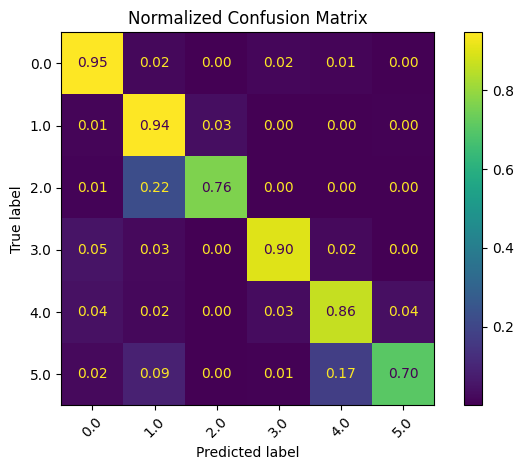

In [ ]:
# Pipeline: TF-IDF + Logistic Regression
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1,2),
        max_features=30000
    )),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
])

# Quick cross-validation for confidence (optional but nice)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring="f1_macro")
print("CV Macro-F1 (3-fold): " + str(np.round(cv_scores.mean(), 4)) + " ± " + str(np.round(cv_scores.std(), 4)))

# Fit and evaluate
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix (normalized)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig = plt.figure(figsize=(6, 6))
disp.plot(values_format=".2f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()


  emotion  precision    recall        f1  support
0     0.0   0.941606  0.947386  0.944487     9123
1     1.0   0.905864  0.944037  0.924556    10489
3     3.0   0.922318  0.901081  0.911576     4256
4     4.0   0.875787  0.863431  0.869565     3544
2     2.0   0.830638  0.763096  0.795436     2558
5     5.0   0.806714  0.704889  0.752372     1125


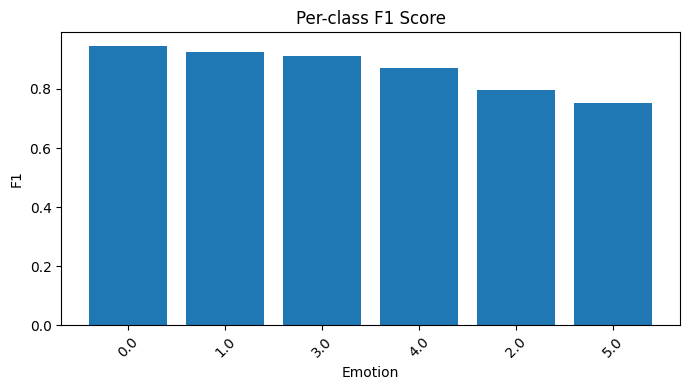


Top 12 words per emotion:

0.0: dull, aching, vain, abused, needy, damaged, troubled, doomed, fake, messy, beaten, disturbed
1.0: convinced, innocent, resolved, acceptable, valuable, pleasant, trusting, mellow, popular, vital, superior, worthwhile
2.0: tender, longing, sympathetic, gentle, romantic, naughty, caring, delicate, supportive, lovely, horny, loyal
3.0: dangerous, distracted, rude, violent, dissatisfied, bothered, fucked, bitchy, greedy, petty, wronged, bitter
4.0: shaken, reluctant, terrified, shaky, paranoid, apprehensive, hesitant, pressured, shy, vulnerable, uncertain, intimidated
5.0: impressed, amazed, surprised, shocked, curious, funny, dazed, stunned, strange, amazing, weird, overwhelmed

Sample prediction for: I am really happy with my life and excited for the future!
Predicted emotion: 1.0
Probabilities:
1.0 -> 0.959
0.0 -> 0.01
4.0 -> 0.01
2.0 -> 0.009
3.0 -> 0.008

Saved model to /content/emotion_model.joblib


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Per-class precision/recall/F1
prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=np.unique(y_test), zero_division=0)
per_class = pd.DataFrame({
    "emotion": le.inverse_transform(np.unique(y_test)),
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": support
}).sort_values("f1", ascending=False)
print(per_class)

# Bar chart of F1
plt.figure(figsize=(7,4))
plt.bar(per_class["emotion"], per_class["f1"])
plt.title("Per-class F1 Score")
plt.xlabel("Emotion")
plt.ylabel("F1")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Top indicative words per emotion (from Logistic Regression coefficients) ===
# Refit on ALL data to get global top words
pipe.fit(X, y)
vectorizer = pipe.named_steps["tfidf"]
clf = pipe.named_steps["clf"]

feature_names = np.array(vectorizer.get_feature_names_out())
coef = clf.coef_  # shape: [n_classes, n_features]

def top_words_for_class(class_index, k=10):
    # largest positive coefficients indicate words pushing towards that class
    topk_idx = np.argsort(coef[class_index])[-k:][::-1]
    return feature_names[topk_idx]

k = 12
print("\nTop " + str(k) + " words per emotion:\n")
for idx, emotion in enumerate(le.classes_):
    words = top_words_for_class(idx, k=k)
    print(emotion + ": " + ", ".join(words))

# === Single text prediction demo ===
def predict_emotion(text):
    pred_idx = pipe.predict([text])[0]
    if hasattr(clf, "predict_proba"):
        probs = pipe.predict_proba([text])[0]
        pairs = list(zip(le.classes_, np.round(probs, 3)))
        pairs_sorted = sorted(pairs, key=lambda x: x[1], reverse=True)
        print("Predicted emotion: " + le.inverse_transform([pred_idx])[0])
        print("Probabilities:")
        for emo, p in pairs_sorted[:5]:
            print(emo + " -> " + str(p))
    else:
        print("Predicted emotion: " + le.inverse_transform([pred_idx])[0])

sample_text = "I am really happy with my life and excited for the future!"
print("\nSample prediction for: " + sample_text)
predict_emotion(sample_text)

# Save model + label encoder for reuse/demo
joblib.dump(pipe, "/content/emotion_model.joblib")
joblib.dump(le, "/content/label_encoder.joblib")
print("\nSaved model to /content/emotion_model.joblib")


In [ ]:
import gradio as gr
import numpy as np

model = joblib.load("/content/emotion_model.joblib")
labeler = joblib.load("/content/label_encoder.joblib")

def infer(text):
    if text is None or len(text.strip()) == 0:
        return "Please enter some text.", {}
    clf = model.named_steps["clf"]
    if hasattr(clf, "predict_proba"):
        prob = model.predict_proba([text])[0]
        pred = np.argmax(prob)
        label = labeler.inverse_transform([pred])[0]
        # Convert to dict for label + confidence bars
        conf = {labeler.inverse_transform([i])[0]: float(prob[i]) for i in range(len(prob))}
        return label, conf
    else:
        pred = model.predict([text])[0]
        label = labeler.inverse_transform([pred])[0]
        return label, {}

demo = gr.Interface(
    fn=infer,
    inputs=gr.Textbox(lines=3, label="Enter a sentence"),
    outputs=[gr.Label(num_top_classes=5, label="Predicted Emotion"),
             gr.Label(label="Confidence Scores")],
    title="Emotion Detector (TF-IDF + Logistic Regression)",
    description="Type any sentence to see the predicted emotion."
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3905a478658025692f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
